In [1]:
from triqs.gf import *
from triqs.gf.tools import fit_legendre
import triqs.utility.mpi as mpi
from triqs.operators import *
from triqs_cthyb import Solver
from h5 import *
import numpy as np
import os.path
import sys
import os
import shutil
%matplotlib inline
from triqs.plot.mpl_interface import plt,oplot

Starting serial run at: 2024-08-09 09:48:10.703093


## Attractive Hubbard Model

Superconductivity can be described using the Hubbard model, similarly to what we did with the Mott insulator in previous tutorials. When looking at the phase diagram for this model we can see that the superconducting and antiferromagnetic states are completly symmetrical around the temperature (T) axis. 

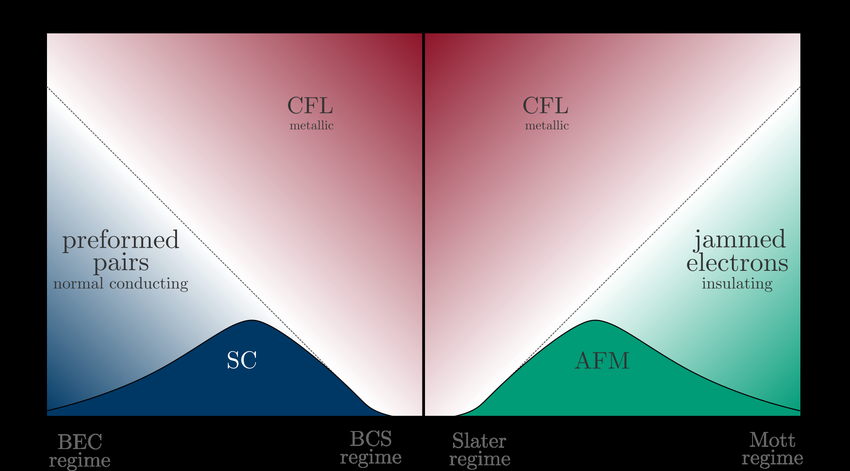!

https://www.researchgate.net/figure/Equilibrium-phase-diagram-of-the-three-dimensional-Hubbard-model-on-cubic-lattice-as-a_fig8_358145714

The Hamiltonian of the Hubbard model at half filling is described by:

$$
H_U=-t\sum_{\langle ij\sigma \rangle} c_{i \sigma}^\dagger c_{j \sigma} + U(n_\uparrow - 1/2) (n_\downarrow - 1/2)
$$

Where if U is negative, states completely filled with electrons and empty states minimize the energy. 

There are 2 degenerate states that can be the ground state of this Hamiltonian. The superconducting state (SC) described by a superposition of empty and full state:

$$
|SC \rangle = \frac{1}{\sqrt{2}}(|0 \rangle + |\uparrow \downarrow \rangle) 
$$

And the charge density wave state (CDW) described by a lattice with half the sites full and half the sites empty.

$$
|CDW \rangle =\begin{cases}
|0\rangle, & \text{sites A}\\
|\uparrow \downarrow \rangle, & \text{sites B}
\end{cases}
$$

When trying to solve the hamiltonian, those two states will compete with eachother. In order to encourage the apparition of a superconducting state, we consider a very high mixing that will break the structure of the Green function in the lattice for CDW by mixing most of new structures of each iterations with some of old structure from prior iterations.


In order to solve this Hamiltonian using the same method as for the Mott insulator, we will need to use the following mapping:



$$
\begin{cases}
c_\uparrow \rightarrow c_\uparrow &\\
c_\downarrow \rightarrow (-1)^ic_\downarrow^\dagger & 
\end{cases}
$$

$$
H_U \rightarrow H_{-U} \\
$$

In term, we will also get: 

$$
n_\downarrow=c_\downarrow^\dagger c_\downarrow \rightarrow c_\downarrow c_\downarrow^\dagger 
$$
Thus, we can use the same method than for Mott insulator to express superconductivity. 

# Nambu superconductivity model

The Nambu formalism for superconductivity permits the description of superconductivity in a one particle Green's function. To describe superconductivity, one has to be able to consider electron electron pairs, but also hole-hole and electron-hole pairs. The Nambu spinors that allow such a description are:
$$\psi = \begin{pmatrix}
    c_\uparrow \\
    c_\downarrow^\dagger
\end{pmatrix}
\quad
\psi^\dagger = \begin{bmatrix}
    c_\uparrow^\dagger & c_\downarrow
\end{bmatrix}$$


The Green's function in the Nambu formalism is thus:
$$G = - \langle T_\tau c(\tau)c^\dagger \rangle   \rightarrow -\langle T_\tau \psi(\tau) \psi^\dagger \rangle$$    
$$
G = - \langle T \begin{pmatrix}
    c_{\uparrow} (\tau) c_{\uparrow}^\dagger & c_\downarrow (\tau) c_\uparrow \\
    c_\uparrow^\dagger (\tau) c_\downarrow^\dagger & c_\downarrow^\dagger (\tau) c_\downarrow 
\end{pmatrix} \rangle =  \langle \begin{pmatrix}
    g(\tau) & F(\tau) \\
    F(\tau)* & -g(-\tau) 
\end{pmatrix} \rangle
$$

As expected, the Green's function is hermitian. For any classical situation, we would expect the $\langle F(\tau) \rangle$ to be nul however, since superconductivity does not conserve the number of particles, we suppose $F(\tau)$ will be non-zero for a superconducting state. Nevertheless, since superconductivity exists in a "mexican-hat" potential, the Green's function will tend to evolve in such a way that $\langle F(\tau) \rangle=0$ even under the critical T (we are stuck on the central maximum of the potential). To overcome this problem we will break the symmetry by adding a very small $\Delta_0$ in the off diagonal term of the Green's function, which will allow for the Green's function to evolve toward superconductivity if under critical T or toward normal state if over critical T. 

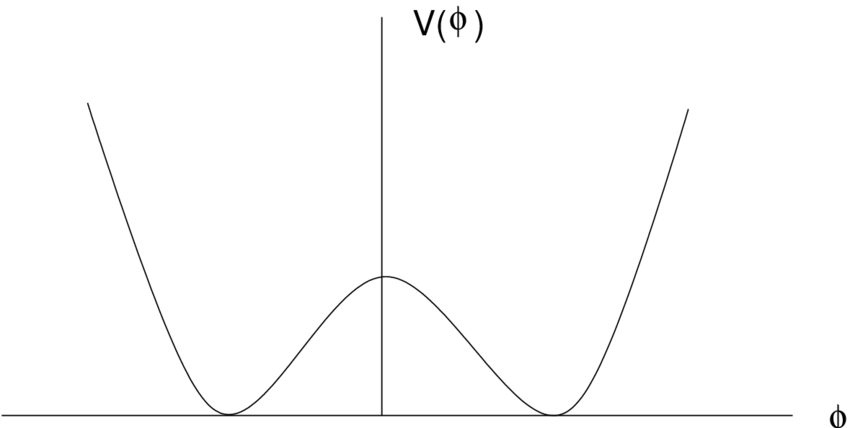!

To keep up with the matrix form of the Nambu formalism,  the Weiss field can be written as:

$$
{\cal G}_{0}^{-1} (i\omega_n) = i\omega_n  + \mu \sigma_3 - t^2 \sigma_3 G_{ \sigma} (i\omega_n) \sigma_3
$$

Where $\sigma_3$ is the Pauli matrice $ \begin{pmatrix}
    1 & 0 \\
    0 & -1
\end{pmatrix}$

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1:
Finish the Nambu superconductor model below to obtain the Green function.Observe the difference between U>0 and U<0. Explore and try to remove the value of delta to see the effect. Create a plot of $F(\tau=0)$ as a function of iterations.

In [2]:
%%time
# Other parameters for the calculation


niter0 = 0
niter = 30   #nloop
t = 1
mixing = 0.7    #To break CDW wave
Delta0 = 0.005 # 0.01


U=-4
beta=10    #Rember, beta= 1/T
mu = 0#U/2   #half filling
y=[]
n_iw = int(15*beta)     
n_tau = int(100*beta)
# Interacting Hamiltonian in the Nambu basis
h_int = U * (n('N', 0)-1/2) * (c('N', 1)*c_dag('N', 1)-1/2)
p = {'n_warmup_cycles': 5000,      
             'n_cycles': 10000,   #int(nc*np.abs(U)*beta/mpi.size)
             'random_seed': 123 * mpi.rank + 321,
             'length_cycle': int(20*beta),
             'measure_G_tau': True,
             # 'measure_density_matrix': True,
             'use_norm_as_weight': True,
             # 'perform_tail_fit': True,
             # 'fit_min_n': int(beta*2)+3,
             # 'fit_max_n': int(beta*4)+4,
             'imag_threshold': 1e-11,
             # 'fit_max_moment': 3,
    }
print("U = %.2f, Beta = %i" % (U, beta))


S = Solver(beta = beta, n_iw = n_iw, n_tau = n_tau, gf_struct = [('N', 2)])   



###################################### Break the "mexican-hat" symmetry ##################################################3


# Symmetry breaking field
Sigma = S.G0_iw['N'].copy()
Sigma.zero()


Sigma[0, 1] << Delta0
Sigma[1, 0] << Delta0

########################################### Finish the code ###################################################################

# SemiCircular DOS
S.G0_iw['N'][0, 0] << SemiCircular(2*t)
S.G0_iw['N'][1, 1] = S.G0_iw['N'][0, 0].copy()
S.G0_iw['N'][1, 1] << -1 * S.G0_iw['N'][1, 1].conjugate()

# Inversion of the Green function
S.G_iw['N'] << inverse(inverse(S.G0_iw['N']) - Sigma)

for i in range(niter0, niter):
    print("########## Beta = %.2f ##### Iteration = %i" % (beta, i))
    
      # Self-consistency relation
    S.G0_iw['N'][0, 0] << iOmega_n + mu - t**2 * S.G_iw['N'][0, 0]
    S.G0_iw['N'][0, 1] << + t**2 * S.G_iw['N'][0, 1]
    S.G0_iw['N'][1, 0] << + t**2 * S.G_iw['N'][1, 0]
    S.G0_iw['N'][1, 1] << iOmega_n - mu - t**2 * S.G_iw['N'][1, 1]
    S.G0_iw['N'].invert()

    
     # Save an older Green function for mixing after solve.
    old_G_iw = S.G_iw.copy()
    old_Sigma = S.Sigma_iw.copy()['N']
    S.solve(h_int = h_int, **p)

    # Mixing to avoid density fluctuations
    S.G_iw << mixing*S.G_iw + (1-mixing)*old_G_iw

    # Calculation of the self-energy
    Sigma = S.Sigma_iw['N']
    y+=[S.G_tau['N'][1,0][Idx(0)]]
    
    
    

U = -4.00, Beta = 10
########## Beta = 10.00 ##### Iteration = 0

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
1 + -2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
09:48:22   8% ETA 00:00:01 cycle 439 of 5000
09:48:23 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
09:48:23   4% ETA 00:00:02 cycle 457 of 10000
09:48:25  94% ETA 00:00:00 cycle 9495 of 10000
09:48:25 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00298287
Average order         | 0.000309301
Average sign          | 0.000297915
G_tau measure         | 0.00375388
Total measure time    | 0.00734397
[Rank 0] Acce

In [2]:
#Do not use - debug purpose
%%time
# Other parameters for the calculation


niter0 = 0
niter = 30   #nloop
t = 1
mixing = 0.7    #To break CDW wave
Delta0 = 0.005 # 0.01


U=-4
beta=10    #Rember, beta= 1/T
mu = 0#U/2   #half filling
y=[]
n_iw = int(15*beta)     
n_tau = int(100*beta)
# Interacting Hamiltonian in the Nambu basis
h_int = U * (n('N', 0)-1/2) * (c('N', 1)*c_dag('N', 1)-1/2)
p = {'n_warmup_cycles': 5000,      
             'n_cycles': 10000,   #int(nc*np.abs(U)*beta/mpi.size)
             'random_seed': 123 * mpi.rank + 321,
             'length_cycle': int(20*beta),
             'measure_G_tau': True,
             # 'measure_density_matrix': True,
             'use_norm_as_weight': True,
             # 'perform_tail_fit': True,
             # 'fit_min_n': int(beta*2)+3,
             # 'fit_max_n': int(beta*4)+4,
             'imag_threshold': 1e-11,
             # 'fit_max_moment': 3,
    }
print("U = %.2f, Beta = %i" % (U, beta))


S = Solver(beta = beta, n_iw = n_iw, n_tau = n_tau, gf_struct = [('N', 2)])   



###################################### Break the "mexican-hat" symmetry ##################################################3


# Symmetry breaking field
Sigma = S.G0_iw['N'].copy()
Sigma.zero()


Sigma[0, 1] << Delta0
Sigma[1, 0] << Delta0

########################################### Finish the code ###################################################################

# SemiCircular DOS
S.G0_iw['N'][0, 0] << SemiCircular(2*t)
S.G0_iw['N'][1, 1] = S.G0_iw['N'][0, 0].copy()
S.G0_iw['N'][1, 1] << -1 * S.G0_iw['N'][1, 1].conjugate()

# Inversion of the Green function
S.G_iw['N'] << inverse(inverse(S.G0_iw['N']) - Sigma)

for i in range(niter0, niter):
    print("########## Beta = %.2f ##### Iteration = %i" % (beta, i))
    
      # Self-consistency relation
    S.G0_iw['N'][0, 0] << iOmega_n + mu - t**2 * S.G_iw['N'][0, 0]
    S.G0_iw['N'][0, 1] << + t**2 * S.G_iw['N'][0, 1]
    S.G0_iw['N'][1, 0] << + t**2 * S.G_iw['N'][1, 0]
    S.G0_iw['N'][1, 1] << iOmega_n - mu - t**2 * S.G_iw['N'][1, 1]
    S.G0_iw['N'].invert()

    
     # Save an older Green function for mixing after solve.
    old_G_iw = S.G_iw.copy()
    old_Sigma = S.Sigma_iw.copy()['N']
    S.solve(h_int = h_int, **p)

    # Mixing to avoid density fluctuations
    S.G_iw << mixing*S.G_iw + (1-mixing)*old_G_iw

    # Calculation of the self-energy
    Sigma = S.Sigma_iw['N']
    y+=[S.G_tau['N'][1,0][Idx(0)]]
    
    
    

U = -4.00, Beta = 10
########## Beta = 10.00 ##### Iteration = 0

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
1 + -2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
17:15:38   8% ETA 00:00:01 cycle 442 of 5000
17:15:39 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
17:15:40   4% ETA 00:00:02 cycle 466 of 10000
17:15:42  96% ETA 00:00:00 cycle 9621 of 10000
17:15:42 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00285897
Average order         | 0.000300716
Average sign          | 0.000294885
G_tau measure         | 0.00366126
Total measure time    | 0.00711583
[Rank 0] Acce

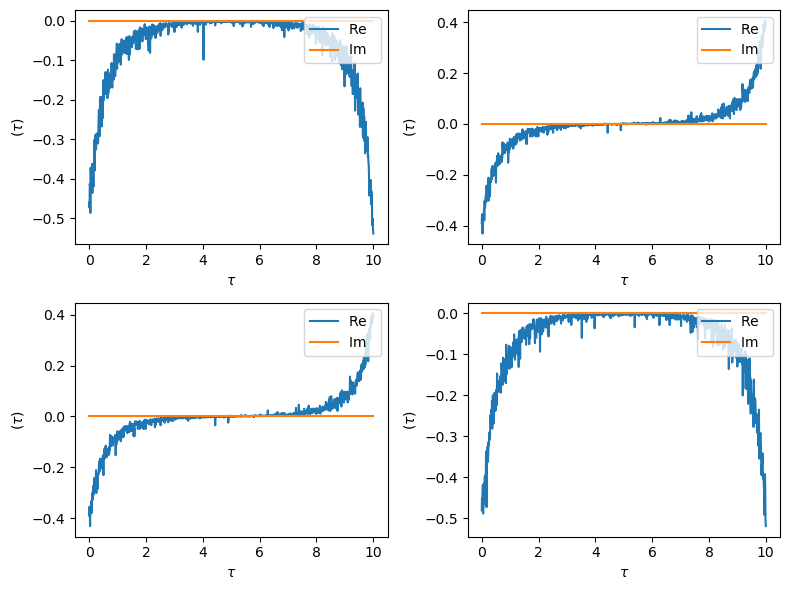

In [3]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)  # (rows, columns, panel number)
oplot(S.G_tau['N'][0,0])
plt.subplot(2, 2, 2)  # (rows, columns, panel number)
oplot(S.G_tau['N'][1,0])
plt.subplot(2, 2, 3)  # (rows, columns, panel number)
oplot(S.G_tau['N'][0,1])
plt.subplot(2, 2, 4)  # (rows, columns, panel number)
oplot(S.G_tau['N'][1,1])



plt.tight_layout()

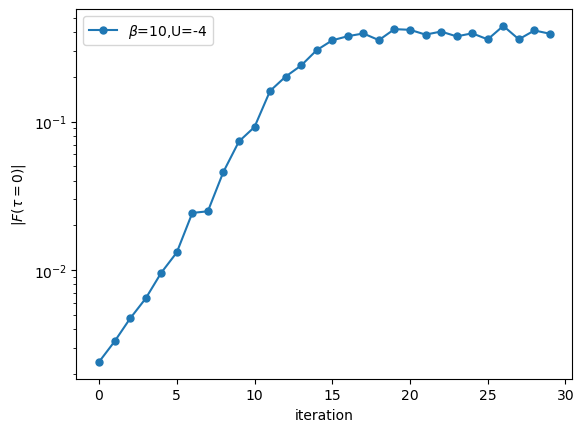

In [4]:
plt.semilogy(np.arange(niter0,niter,1),abs(np.array(y)),label=rf'$\beta$={beta},U={U}',linestyle='-',marker='o',markersize=5)

plt.xlabel('iteration')
plt.ylabel(r'|$F(\tau=0)$|')
plt.legend(loc='best')
        

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2:

Now create a plot of $F(\tau=0)$ with regards to iterations for many different temperature. For what temperature is the model superconductor? What is the cutoff?

In [4]:
#Old function do not use
def DMFT(beta,U,n_cycles=10000,own_path="",niter0=0,niter=30):
    
    n_iw = int(15*beta)
    n_tau = int(100*beta)

    mixing=0.7
    mu = 0 #U/2 
    Delta0=0.005
    t=1
    # Interacting Hamiltonian in the Nambu basis
    h_int = U * (n('N', 0)-1/2) * (c('N', 1)*c_dag('N', 1) - 1/2)
    p = {'n_warmup_cycles': 5000,#int(4000*beta),
                 'n_cycles': n_cycles,#int(nc*np.abs(U)*beta/mpi.size)
                 'random_seed': 123 * mpi.rank + 321,
                 'length_cycle': int(20*beta),
                 'measure_G_tau': True,
                 #'measure_density_matrix': True,
                 'use_norm_as_weight': True,
                 #'perform_tail_fit': True,
                 #'fit_min_n': int(beta*2)+3,
                 #'fit_max_n': int(beta*4)+4,
                 'imag_threshold': 1e-11,
                 #'fit_max_moment': 3
        }
    print("U = %.2f, Beta = %i" % (U, beta))
    S2 = Solver(beta = beta, n_iw = n_iw, n_tau = n_tau, gf_struct = [('N', 2)])    
    
    # Symmetry breaking field
    Sigma = S2.G0_iw['N'].copy()
    Sigma.zero()
    Sigma[0, 1] << Delta0
    Sigma[1, 0] << Delta0

    # SemiCircular DOS
    S2.G0_iw['N'][0, 0] << SemiCircular(2*t)
    S2.G0_iw['N'][1, 1] = S2.G0_iw['N'][0, 0].copy()
    S2.G0_iw['N'][1, 1] << -1 * S2.G0_iw['N'][1, 1].conjugate()

    # Inversion of the Green function
    S2.G_iw['N'] << inverse(inverse(S2.G0_iw['N']) - Sigma)
    
    if own_path=="":
        path=f"U{U}_b{beta}_2eSC"
    else:
        path=own_path
    
    
    
    if os.path.exists(path):
        try:
            shutil.rmtree(path)
            print(f"Directory '{path}' removed.")
        except OSError as error:
            print(f"Error removing directory '{path}': {error}")


    try:
        os.makedirs(path)
        print(f"Directory '{path}' created successfully.")
    except OSError as error:
        print(f"Directory '{path}' creation failed: {error}")


    for i in range(niter0, niter):
        print("########## Beta = %.2f ##### Iteration = %i" % (beta, i))

          # Self-consistency relation
        S2.G0_iw['N'][0, 0] << iOmega_n + mu - t**2 * S2.G_iw['N'][0, 0]
        S2.G0_iw['N'][0, 1] << + t**2 * S2.G_iw['N'][0, 1]
        S2.G0_iw['N'][1, 0] << + t**2 * S2.G_iw['N'][1, 0]
        S2.G0_iw['N'][1, 1] << iOmega_n - mu - t**2 * S2.G_iw['N'][1, 1]
        S2.G0_iw['N'].invert()
        
         # Save an older Green function for mixing after solve.
        old_G_iw = S2.G_iw.copy()
        old_Sigma = S2.Sigma_iw.copy()['N']
        S2.solve(h_int = h_int, **p)

        # Mixing to avoid density fluctuations
        S2.G_iw << mixing*S2.G_iw + (1-mixing)*old_G_iw

        # Calculation of the self-energy
        Sigma = S2.Sigma_iw['N']
        with HDFArchive(f"{path}/Solver-b{beta}-U{U}-i{i}.h5", 'w') as arch: arch[f"Solver-b{beta}-U{U}-i{i}"] = S2 
        
    return S2.G_tau['N'][1,0][Idx(0)]

In [ ]:
#Debuging purpose do not use
%%time
# Other parameters for the calculation


niter0 = 0
niter = 30   #nloop
t = 1
mixing = 0.7    #To break CDW wave
Delta0 = 0.005 # 0.01


U=-4
beta=7  #Rember, beta= 1/T
mu = 0#U/2   #half filling
y=[]
n_iw = int(15*beta)     
n_tau = int(100*beta)
# Interacting Hamiltonian in the Nambu basis
h_int = U * (n('N', 0)-1/2) * (c('N', 1)*c_dag('N', 1)-1/2)
p = {'n_warmup_cycles': 5000,      
             'n_cycles': 10000,   #int(nc*np.abs(U)*beta/mpi.size)
             'random_seed': 123 * mpi.rank + 321,
             'length_cycle': int(20*beta),
             'measure_G_tau': True,
             # 'measure_density_matrix': True,
             'use_norm_as_weight': True,
             # 'perform_tail_fit': True,
             # 'fit_min_n': int(beta*2)+3,
             # 'fit_max_n': int(beta*4)+4,
             'imag_threshold': 1e-11,
             # 'fit_max_moment': 3,
    }
print("U = %.2f, Beta = %i" % (U, beta))


S = Solver(beta = beta, n_iw = n_iw, n_tau = n_tau, gf_struct = [('N', 2)])   



###################################### Break the "mexican-hat" symmetry ##################################################3


# Symmetry breaking field
Sigma = S.G0_iw['N'].copy()
Sigma.zero()


Sigma[0, 1] << Delta0
Sigma[1, 0] << Delta0

########################################### Finish the code ###################################################################

# SemiCircular DOS
S.G0_iw['N'][0, 0] << SemiCircular(2*t)
S.G0_iw['N'][1, 1] = S.G0_iw['N'][0, 0].copy()
S.G0_iw['N'][1, 1] << -1 * S.G0_iw['N'][1, 1].conjugate()

# Inversion of the Green function
S.G_iw['N'] << inverse(inverse(S.G0_iw['N']) - Sigma)

for i in range(niter0, niter):
    print("########## Beta = %.2f ##### Iteration = %i" % (beta, i))
    
      # Self-consistency relation
    S.G0_iw['N'][0, 0] << iOmega_n + mu - t**2 * S.G_iw['N'][0, 0]
    S.G0_iw['N'][0, 1] << + t**2 * S.G_iw['N'][0, 1]
    S.G0_iw['N'][1, 0] << + t**2 * S.G_iw['N'][1, 0]
    S.G0_iw['N'][1, 1] << iOmega_n - mu - t**2 * S.G_iw['N'][1, 1]
    S.G0_iw['N'].invert()

    
     # Save an older Green function for mixing after solve.
    old_G_iw = S.G_iw.copy()
    old_Sigma = S.Sigma_iw.copy()['N']
    S.solve(h_int = h_int, **p)

    # Mixing to avoid density fluctuations
    S.G_iw << mixing*S.G_iw + (1-mixing)*old_G_iw

    # Calculation of the self-energy
    Sigma = S.Sigma_iw['N']
    y+=[S.G_tau['N'][1,0][Idx(0)]]
    
    
    

U = -4.00, Beta = 7
########## Beta = 7.00 ##### Iteration = 0


In [5]:
def DMFT(beta,U,n_cycles=10000,own_path="",niter0=0,niter=30):
    
    n_iw = int(15*beta)
    n_tau = int(100*beta)

    mixing=0.7
    mu = 0 #U/2 
    Delta0=0.005
    t=1
    # Interacting Hamiltonian in the Nambu basis
    h_int = U * (n('N', 0)-1/2) * (c('N', 1)*c_dag('N', 1) - 1/2)
    p = {'n_warmup_cycles': 5000,#int(4000*beta),
                 'n_cycles': n_cycles,#int(nc*np.abs(U)*beta/mpi.size)
                 'random_seed': 123 * mpi.rank + 321,
                 'length_cycle': int(20*beta),
                 'measure_G_tau': True,
                 #'measure_density_matrix': True,
                 'use_norm_as_weight': True,
                 #'perform_tail_fit': True,
                 #'fit_min_n': int(beta*2)+3,
                 #'fit_max_n': int(beta*4)+4,
                 'imag_threshold': 1e-11,
                 #'fit_max_moment': 3
        }
    print("U = %.2f, Beta = %i" % (U, beta))
    S2 = Solver(beta = beta, n_iw = n_iw, n_tau = n_tau, gf_struct = [('N', 2)])    
    
    # Symmetry breaking field
    Sigma = S2.G0_iw['N'].copy()
    Sigma.zero()
    Sigma[0, 1] << Delta0
    Sigma[1, 0] << Delta0

    # SemiCircular DOS
    S2.G0_iw['N'][0, 0] << SemiCircular(2*t)
    S2.G0_iw['N'][1, 1] = S2.G0_iw['N'][0, 0].copy()
    S2.G0_iw['N'][1, 1] << -1 * S2.G0_iw['N'][1, 1].conjugate()

    # Inversion of the Green function
    S2.G_iw['N'] << inverse(inverse(S2.G0_iw['N']) - Sigma)
    
    if own_path=="":
        path=f"U{U}_b{beta}_2eSC"
    else:
        path=own_path
    
    
    

    for i in range(niter0, niter):
        print("########## Beta = %.2f ##### Iteration = %i" % (beta, i))

          # Self-consistency relation
        S2.G0_iw['N'][0, 0] << iOmega_n + mu - t**2 * S2.G_iw['N'][0, 0]
        S2.G0_iw['N'][0, 1] << + t**2 * S2.G_iw['N'][0, 1]
        S2.G0_iw['N'][1, 0] << + t**2 * S2.G_iw['N'][1, 0]
        S2.G0_iw['N'][1, 1] << iOmega_n - mu - t**2 * S2.G_iw['N'][1, 1]
        S2.G0_iw['N'].invert()
        
         # Save an older Green function for mixing after solve.
        old_G_iw = S2.G_iw.copy()
        old_Sigma = S2.Sigma_iw.copy()['N']
        S2.solve(h_int = h_int, **p)

        # Mixing to avoid density fluctuations
        S2.G_iw << mixing*S2.G_iw + (1-mixing)*old_G_iw

        # Calculation of the self-energy
        Sigma = S2.Sigma_iw['N']
        with HDFArchive(f"{path}.h5", 'a') as arch: arch[f"Solver-iter{i}"] = S2 
        
    return S2.G_tau['N'][1,0][Idx(0)]

In [5]:
path=f"U{U}_b{beta}_2eSC"
with HDFArchive(f"{path}.h5","r") as R:
    keys = list(R.keys())
    print(keys)

['Solver-b10-U-4-i29']


In [ ]:
%%time
betas=[2,3,4,5,6,8,10]
#betas = [2,3,4]
U=-4
niter=30
for beta in betas:
    DMFT(beta=beta,U=U, niter=niter)



U = -4.00, Beta = 2
########## Beta = 2.00 ##### Iteration = 0

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
1 + -2*c_dag('N',0)*c('N',0) + -2*c_dag('N',1)*c('N',1) + 4*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
09:50:29  67% ETA 00:00:00 cycle 3377 of 5000
09:50:29 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
09:50:29  33% ETA 00:00:00 cycle 3309 of 10000
09:50:29 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00273784
Average order         | 0.000301089
Average sign          | 0.00026073
G_tau measure         | 0.000732752
Total measure time    | 0.00403242
[Rank 0] Acceptance rate for all moves:
Move set Insert two 

In [8]:
path

'U-4_b2_2eSC'

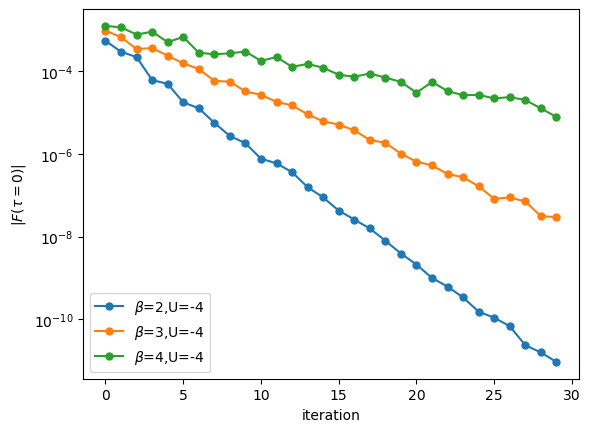

In [4]:
niter0=0
for beta in betas:
    y=[]
    path=f"U{U}_b{beta}_2eSC"
    for i in range(niter0,niter):
        with HDFArchive(f"{path}.h5","r") as R:
            S_ = R[f"Solver-iter{i}"]
        y+=[S_.G_tau['N'][1,0][Idx(0)]]

    plt.semilogy(np.arange(niter0,niter,1),abs(np.array(y)),label=rf'$\beta$={beta},U={U}',linestyle='-',marker='o',markersize=5)
plt.xlabel('iteration')
plt.ylabel(r'|$F(\tau=0)$|')
plt.legend(loc='best')

If $F(\tau=0)$ is converging to a value, it is a superconducting state. If it goes to 0, superconductivity was not reach. The temperature at which the $F(\tau=0)$ creates a plateau (here $\beta=5$) corresponds to the critical temperature.

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 3:

Now verify the impact of multiple U on the critical temperature for superconductivity.

In [ ]:
%%time
Us=[-3,-4,-5]
betas=[3,4,5,6,7,8,9,10]
niter=20
for U in Us:
    for beta in betas:
        path=f"h5_U{U}_b{beta}"
        DMFT(beta=beta,U=U, niter=niter,own_path=path)

U = -3.00, Beta = 3
Directory 'h5_U-3_b3' removed.
Directory 'h5_U-3_b3' created successfully.
########## Beta = 3.00 ##### Iteration = 0

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.75 + -1.5*c_dag('N',0)*c('N',0) + -1.5*c_dag('N',1)*c('N',1) + 3*c_dag('N',0)*c_dag('N',1)*c('N',1)*c('N',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
15:23:47  35% ETA 00:00:00 cycle 1781 of 5000
15:23:47 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
15:23:47  17% ETA 00:00:00 cycle 1764 of 10000
15:23:47 100% ETA 00:00:00 cycle 9999 of 10000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.0027827 
Average order         | 0.000334284
Average sign          | 0.000265724
G_tau measure         | 0.00106881
Total measure

## U dependence

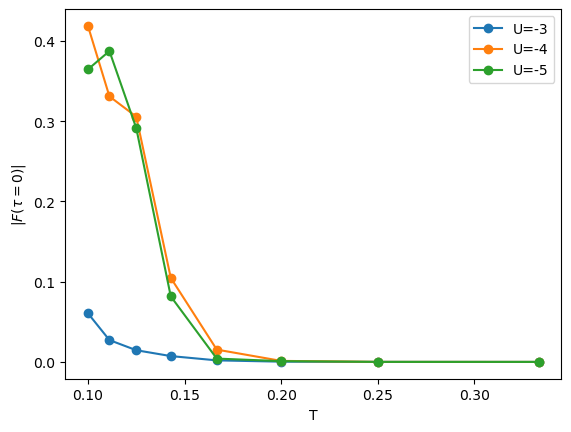

In [16]:
for U in Us:
    y2=[]
    for beta in betas:
   
        path=f"h5_U{U}_b{beta}"
        with HDFArchive(f"{path}/Solver-b{beta}-U{U}-i{niter-1}.h5","r") as R:
            S = R[f"Solver-b{beta}-U{U}-i{niter-1}"]
        y2+=[S.G_tau['N'][1,0][Idx(0)]]

    
    plt.plot(1/np.array(betas),-1*np.array(y2),marker='o',label=f'U={U}')
plt.xlabel('T')
plt.ylabel(r'|$F(\tau=0)$|')
plt.legend(loc='best')

Superconductivity is reached when $F(\tau=0)$ is non zero. U=-4 is optimal to obtain superconductivity as it has the highest critical temperature. If the U parameter is changed, then the critical temperature for superconductivity is also changed. 